In [48]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
from datetime import datetime

from sklearn.pipeline import Pipeline

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, RobustScaler
from sklearn.compose import ColumnTransformer

from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from xgboost import XGBClassifier

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import log_loss

## Data Exploration

#### Load data and get principal information about it

In [49]:
train_df = pd.read_csv('train_ml.csv', index_col=0)
test_df = pd.read_csv('test_ml.csv', index_col=0)

In [50]:
train_df.head(2)

,date,org,tld,ccs,bcced,mail_type,images,urls,salutations,designation,chars_in_subject,chars_in_body,updates,personal,promotions,forums,purchases,travel,spam,social
0,"Mon, 15 Oct 2018 08:03:09 +0000 (UTC)",researchgatemail,net,0,0,multipart/alternative,4,28,0,1,47.0,25556,0,1,0,0,0,0,0,1
1,"Thu, 17 Apr 2014 09:12:33 -0700 (PDT)",no-ip,com,0,0,multipart/alternative,6,32,0,0,46.0,19930,1,1,0,0,0,0,0,0


In [51]:
train_df.describe()

,ccs,bcced,images,urls,salutations,designation,chars_in_subject,chars_in_body,updates,personal,promotions,forums,purchases,travel,spam,social
count,39671.000000,39671.000000,39671.000000,39671.000000,39671.000000,39671.000000,39660.000000,3.967100e+04,39671.000000,39671.000000,39671.000000,39671.000000,39671.000000,39671.000000,39671.000000,39671.000000
mean,0.378967,0.002974,9.806332,36.731088,0.395755,0.102317,51.442032,2.321781e+05,0.362406,0.809609,0.199768,0.155807,0.008293,0.002521,0.003832,0.100955
std,2.530353,0.054458,440.393286,144.379127,0.489018,0.303068,34.142227,2.251044e+06,0.480701,0.392614,0.399831,0.362676,0.090690,0.050144,0.061781,0.301273
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,4.500000,0.000000,0.000000,31.000000,4.903000e+03,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,2.000000,18.000000,0.000000,0.000000,43.000000,2.000500e+04,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,9.000000,47.000000,1.000000,0.000000,63.000000,4.800100e+04,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,155.000000,1.000000,83480.000000,21540.000000,1.000000,1.000000,528.000000,7.438108e+07,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [52]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 39671 entries, 0 to 39670
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   date              39671 non-null  object 
 1   org               37994 non-null  object 
 2   tld               37992 non-null  object 
 3   ccs               39671 non-null  int64  
 4   bcced             39671 non-null  int64  
 5   mail_type         39573 non-null  object 
 6   images            39671 non-null  int64  
 7   urls              39671 non-null  int64  
 8   salutations       39671 non-null  int64  
 9   designation       39671 non-null  int64  
 10  chars_in_subject  39660 non-null  float64
 11  chars_in_body     39671 non-null  int64  
 12  updates           39671 non-null  int64  
 13  personal          39671 non-null  int64  
 14  promotions        39671 non-null  int64  
 15  forums            39671 non-null  int64  
 16  purchases         39671 non-null  int64 

#### Exploring links between features and labels

In [53]:
train_df.groupby(['tld','org'])[['updates','personal','promotions','forums','purchases','travel','spam','social']].mean()

,,updates,personal,promotions,forums,purchases,travel,spam,social
tld,org,,,,,,,,
21cf.com,digital,0.500000,1.000000,0.500000,0.0,0.0,0.0,0.0,0.0
33mail.com,mailer1,1.000000,0.058824,0.000000,0.0,0.0,0.0,0.0,0.0
4shared.com,mx2,1.000000,1.000000,0.000000,0.0,0.0,0.0,0.0,0.0
Apple.com,InsideApple,0.545455,0.818182,0.454545,0.0,0.0,0.0,0.0,0.0
BRASSRING.COM,TRM,1.000000,1.000000,0.000000,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...
wix.com,i,1.000000,1.000000,0.000000,0.0,0.0,0.0,0.0,0.0
xerox.com,xrce,0.000000,1.000000,0.000000,0.0,0.0,0.0,0.0,0.0
xoom.com,messages,0.900000,0.733333,0.466667,0.0,0.0,0.0,0.0,0.0


#### Exploring features alone

In [54]:
# Splitting the data into real features and predictions
def split_X_y(Xa):
    return Xa.drop(['updates','personal','promotions','forums','purchases','travel',
                    'spam','social'],axis=1), Xa[['updates','personal','promotions',
                                                  'forums','purchases','travel','spam','social']]

In [55]:
X, y = split_X_y(train_df.copy())
print("Shape of design matrix of training set:", X.shape)
print("Shape of labels matrix of training set:",y.shape)

Shape of design matrix of training set: (39671, 12)
Shape of labels matrix of training set: (39671, 8)


In [56]:
columns = list(X.columns)
categorical_features = X.select_dtypes(include=['object','category']).columns.tolist()
numerical_features = X.select_dtypes(exclude=['object','category']).columns.tolist()

print('Columns:')
print(columns)
print()
print('Categorical features:')
print(categorical_features)
print()
print('Numerical features:')
print(numerical_features)

Columns:
['date', 'org', 'tld', 'ccs', 'bcced', 'mail_type', 'images', 'urls', 'salutations', 'designation', 'chars_in_subject', 'chars_in_body']

Categorical features:
['date', 'org', 'tld', 'mail_type']

Numerical features:
['ccs', 'bcced', 'images', 'urls', 'salutations', 'designation', 'chars_in_subject', 'chars_in_body']


In [57]:
# Display number of missing values for each column
for col in columns:
    print(col,'----------------',X[col].isnull().sum())

date ---------------- 0
org ---------------- 1677
tld ---------------- 1679
ccs ---------------- 0
bcced ---------------- 0
mail_type ---------------- 98
images ---------------- 0
urls ---------------- 0
salutations ---------------- 0
designation ---------------- 0
chars_in_subject ---------------- 11
chars_in_body ---------------- 0


In [58]:
# Display value counts for each categorical feature
for col in categorical_features:
    print("Column", col)
    print(X[col].value_counts())
    print('*****************************')

Column date
Sat, 04 May 2019 18:17:01 -0700          13
Tue, 04 Jun 2019 05:05:20 -0700          12
Tue, 22 Sep 2020 03:28:22 -0700          12
Sun, 03 Nov 2019 08:51:24 -0800          12
Tue, 12 May 2020 05:53:30 -0700          11
                                         ..
Wed, 19 Feb 2020 05:02:54 +0000           1
Wed, 25 May 2016 00:48:37 +0530 (IST)     1
Thu, 19 Mar 2020 04:33:41 +0000           1
Tue, 15 Sep 2015 16:16:43 +0000           1
Tue, 19 Jun 2018 14:48:57 +0000 (UTC)     1
Name: date, Length: 38122, dtype: int64
*****************************
Column org
iiitd             8934
google            2201
usebackpack       1699
amazon            1523
quora             1241
                  ... 
aryaemailer          1
wifirst              1
elsevierhealth       1
dialogflow           1
moqups               1
Name: org, Length: 973, dtype: int64
*****************************
Column tld
com              17682
ac.in             8996
in                1818
org               1739


## Preprocessing, feature engineering

In [59]:
X.columns

Index(['date', 'org', 'tld', 'ccs', 'bcced', 'mail_type', 'images', 'urls',
       'salutations', 'designation', 'chars_in_subject', 'chars_in_body'],
      dtype='object')

#### Dates

In [60]:
# Retrieve day, month, time, year, number of day from the feature "date"
days=['Mon','Tue','Wed','Thu','Fri','Sat','Sun']
months=['Jan','Feb','Mar','Apr','May','Jun','Jul','Sep','Oct','Nov','Dec']

def day_parse(L):
    for day in days:
        if day in L:
            return day

def month_parse(L):
    for month in months:
        if month in L:
            return month

def time_parse(L):
    M="".join(L.split(" "))
    plus=0;minus=0
    for i in range(len(M)):
        if M[i]==':':
            a=i
        if M[i]=='+' and (M[i-1] in ['0','1','2','3','4','5','6','7','8','9']) and (M[i+1] in ['0','1','2','3','4','5','6','7','8','9']):
            plus=i
        if M[i]=='-' and (M[i-1] in ['0','1','2','3','4','5','6','7','8','9']) and (M[i+1] in ['0','1','2','3','4','5','6','7','8','9']):
            minus=i
            
    time1=int(M[a-2:a]+M[a+1:a+3])
    
    
    if plus!=0:
        time2=int(M[plus+1:plus+5])
        time=(time1+time2)%2400
    elif minus!=0:
        time2=int(M[minus+1:minus+5])
        time=(time1-time2)%2400
    elif plus==0 and minus==0:
        time=time1
        
    return time

def year_parse(L):
    M=" ".join(L.split(" "))
    try :
        return int(re.findall('[0-9][0-9][0-9][0-9]',M)[0])
    except:
        return np.nan
    
def number_date_parse(L):
    M=" ".join(L.split(" "))
    try :
        return int(re.findall('[0-9][0-9]',M)[0])
    except:
        return np.nan

In [61]:
def date_process(data1):
    data=data1.copy()
    data['day']=data['date'].apply(day_parse)
    data['month']=data['date'].apply(month_parse)
    data['time']=data['date'].apply(time_parse)
    data['year']=data['date'].apply(year_parse)
    data['number_date']=data['date'].apply(number_date_parse)
    return data

In [62]:
X = date_process(X)

In [63]:
# Dummies creation for months and days
def create_dummies(data):
    return pd.get_dummies(data, columns=['month','day'], prefix='', prefix_sep='')

In [64]:
X = create_dummies(X)

In [65]:
X.columns

Index(['date', 'org', 'tld', 'ccs', 'bcced', 'mail_type', 'images', 'urls',
       'salutations', 'designation', 'chars_in_subject', 'chars_in_body',
       'time', 'year', 'number_date', 'Apr', 'Dec', 'Feb', 'Jan', 'Jul', 'Jun',
       'Mar', 'May', 'Nov', 'Oct', 'Sep', 'Fri', 'Mon', 'Sat', 'Sun', 'Thu',
       'Tue', 'Wed'],
      dtype='object')

#### Ratios

In [66]:
average_url_size=1
def ratio_features(data):
    data['urls_ratio']=data['urls']*average_url_size/data['chars_in_body']
    data['images_ratio']=data['images']/data['chars_in_body']
    data['chars_in_subject_ratio']=data['chars_in_subject']/data['chars_in_body']
    data['salu_design_']=data['salutations']*data['designation']

In [67]:
ratio_features(X)

In [68]:
print(X.columns)
X.head(2)

Index(['date', 'org', 'tld', 'ccs', 'bcced', 'mail_type', 'images', 'urls',
       'salutations', 'designation', 'chars_in_subject', 'chars_in_body',
       'time', 'year', 'number_date', 'Apr', 'Dec', 'Feb', 'Jan', 'Jul', 'Jun',
       'Mar', 'May', 'Nov', 'Oct', 'Sep', 'Fri', 'Mon', 'Sat', 'Sun', 'Thu',
       'Tue', 'Wed', 'urls_ratio', 'images_ratio', 'chars_in_subject_ratio',
       'salu_design_'],
      dtype='object')


,date,org,tld,ccs,bcced,mail_type,images,urls,salutations,designation,...,Mon,Sat,Sun,Thu,Tue,Wed,urls_ratio,images_ratio,chars_in_subject_ratio,salu_design_
0,"Mon, 15 Oct 2018 08:03:09 +0000 (UTC)",researchgatemail,net,0,0,multipart/alternative,4,28,0,1,...,1,0,0,0,0,0,0.001096,0.000157,0.001839,0
1,"Thu, 17 Apr 2014 09:12:33 -0700 (PDT)",no-ip,com,0,0,multipart/alternative,6,32,0,0,...,0,0,0,1,0,0,0.001606,0.000301,0.002308,0


#### Put all the strings in lower case

In [69]:
# Put all the strings in lower case
def lower_case(data):
    for col in data.select_dtypes(include=['object','category']).columns.tolist():
        data[col]=data[col].str.lower()

In [70]:
lower_case(X)

#### Mail types

In [71]:
# Splitting mail_type columns (e.g. "multipart/alternative" -> "multipart" + "alternative")
mail_type = train_df['mail_type'].unique().tolist()

M = []
for l in mail_type:
    a = "".join(str(l).split(" ")).lower()
    M += (a.split('/'))
keys = set(M)

def mail_type_transform(data):
    m=data.shape[0]
    newColumns={}
    for key in keys:
        temp=[]
        for i in range(m):
            if key in list( "".join(str(data['mail_type'].iloc[i]).split(" ")).split('/')):
                temp.append(1)
            else:
                temp.append(0)
        newColumns[key]=temp
    for key in newColumns.keys():
        data[key]=newColumns[key]

In [72]:
mail_type_transform(X)

In [73]:
X.columns

Index(['date', 'org', 'tld', 'ccs', 'bcced', 'mail_type', 'images', 'urls',
       'salutations', 'designation', 'chars_in_subject', 'chars_in_body',
       'time', 'year', 'number_date', 'Apr', 'Dec', 'Feb', 'Jan', 'Jul', 'Jun',
       'Mar', 'May', 'Nov', 'Oct', 'Sep', 'Fri', 'Mon', 'Sat', 'Sun', 'Thu',
       'Tue', 'Wed', 'urls_ratio', 'images_ratio', 'chars_in_subject_ratio',
       'salu_design_', 'html', 'idm', 'mixed', 'calendar', 'text', 'report',
       'nan', 'signed', 'plain', 'alternative', 'multipart', 'related'],
      dtype='object')

#### Dropping useless features

In [74]:
def dropping(data, cols=['date','mail_type','org','tld','nan']):
    data.drop(cols, axis=1, inplace=True)

In [75]:
dropping(X,['date','mail_type','nan'])

In [76]:
print(X.columns)
X.head(2)

Index(['org', 'tld', 'ccs', 'bcced', 'images', 'urls', 'salutations',
       'designation', 'chars_in_subject', 'chars_in_body', 'time', 'year',
       'number_date', 'Apr', 'Dec', 'Feb', 'Jan', 'Jul', 'Jun', 'Mar', 'May',
       'Nov', 'Oct', 'Sep', 'Fri', 'Mon', 'Sat', 'Sun', 'Thu', 'Tue', 'Wed',
       'urls_ratio', 'images_ratio', 'chars_in_subject_ratio', 'salu_design_',
       'html', 'idm', 'mixed', 'calendar', 'text', 'report', 'signed', 'plain',
       'alternative', 'multipart', 'related'],
      dtype='object')


,org,tld,ccs,bcced,images,urls,salutations,designation,chars_in_subject,chars_in_body,...,idm,mixed,calendar,text,report,signed,plain,alternative,multipart,related
0,researchgatemail,net,0,0,4,28,0,1,47.0,25556,...,0,0,0,0,0,0,0,1,1,0
1,no-ip,com,0,0,6,32,0,0,46.0,19930,...,0,0,0,0,0,0,0,1,1,0


#### Correlations

In [77]:
new_df = X.join(y)

In [78]:
new_df.columns

Index(['org', 'tld', 'ccs', 'bcced', 'images', 'urls', 'salutations',
       'designation', 'chars_in_subject', 'chars_in_body', 'time', 'year',
       'number_date', 'Apr', 'Dec', 'Feb', 'Jan', 'Jul', 'Jun', 'Mar', 'May',
       'Nov', 'Oct', 'Sep', 'Fri', 'Mon', 'Sat', 'Sun', 'Thu', 'Tue', 'Wed',
       'urls_ratio', 'images_ratio', 'chars_in_subject_ratio', 'salu_design_',
       'html', 'idm', 'mixed', 'calendar', 'text', 'report', 'signed', 'plain',
       'alternative', 'multipart', 'related', 'updates', 'personal',
       'promotions', 'forums', 'purchases', 'travel', 'spam', 'social'],
      dtype='object')

<AxesSubplot:>

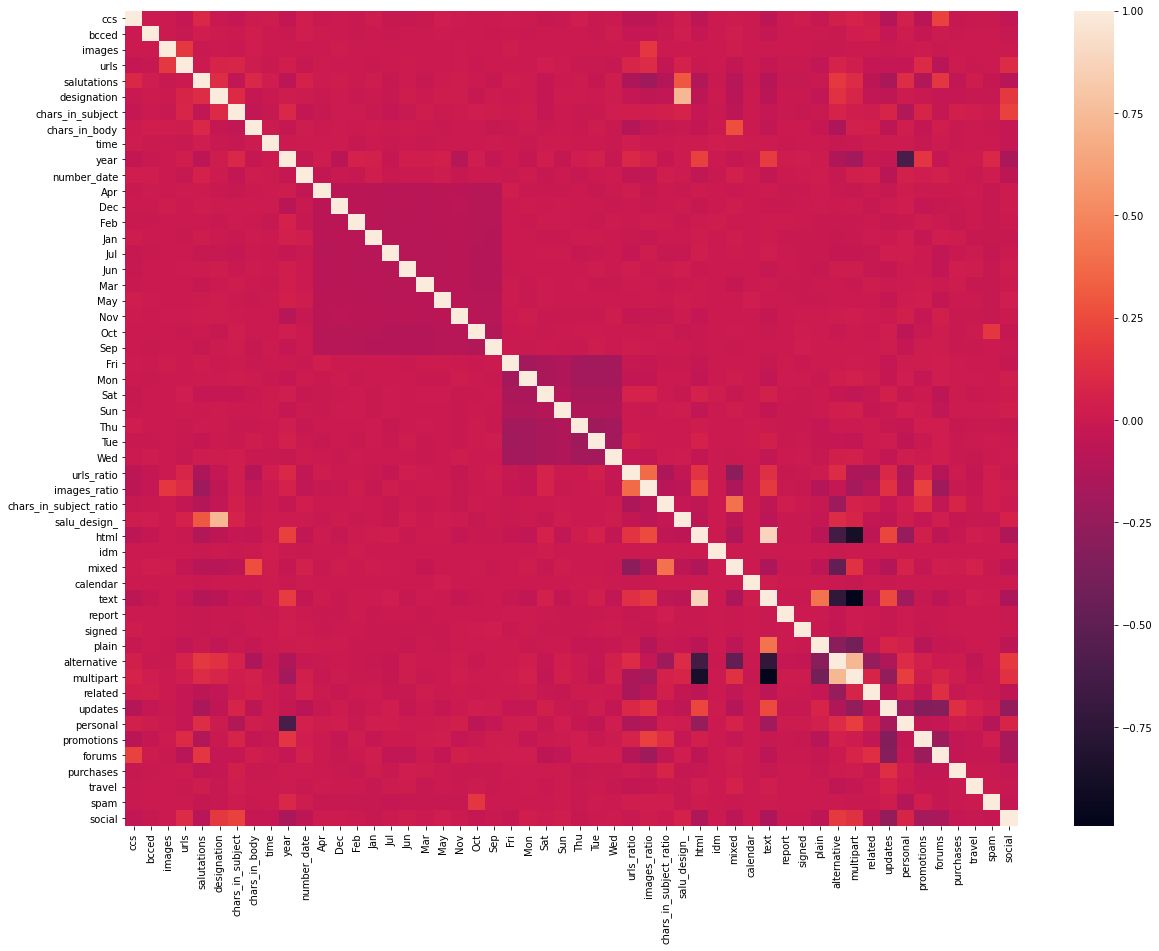

In [79]:
plt.figure(figsize=(20,15))
sns.heatmap(new_df.corr())

#### Remove low variance features

>Threshold=0.00, Features=44
>Threshold=0.01, Features=37
>Threshold=0.02, Features=37
>Threshold=0.03, Features=36
>Threshold=0.04, Features=35
>Threshold=0.05, Features=35
>Threshold=0.06, Features=34
>Threshold=0.07, Features=29
>Threshold=0.08, Features=24
>Threshold=0.09, Features=23
>Threshold=0.10, Features=19
>Threshold=0.11, Features=19
>Threshold=0.12, Features=19
>Threshold=0.13, Features=16
>Threshold=0.14, Features=14
>Threshold=0.15, Features=11
>Threshold=0.16, Features=11
>Threshold=0.17, Features=11
>Threshold=0.18, Features=11
>Threshold=0.19, Features=11
>Threshold=0.20, Features=11
>Threshold=0.21, Features=10
>Threshold=0.22, Features=10
>Threshold=0.23, Features=10
>Threshold=0.24, Features=9
>Threshold=0.25, Features=9
>Threshold=0.26, Features=9
>Threshold=0.27, Features=9
>Threshold=0.28, Features=9
>Threshold=0.29, Features=9
>Threshold=0.30, Features=9
>Threshold=0.31, Features=9
>Threshold=0.32, Features=9
>Threshold=0.33, Features=9
>Threshold=0.34, Feature

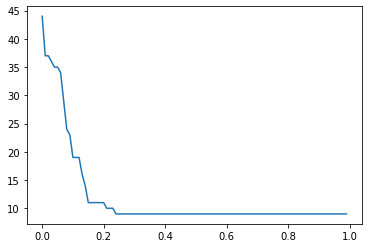

In [80]:
from sklearn.feature_selection import VarianceThreshold

# Define thresholds to check
thresholds = np.arange(0.0, 1, 0.010)
# Apply transform with each threshold
results = list()

for t in thresholds:
    # Define the transform
    transform = VarianceThreshold(threshold=t)
    # Transform the input data
    X_sel = transform.fit_transform(X.select_dtypes(exclude=['object','category']))
    # Determine the number of input features
    n_features = X_sel.shape[1]
    print('>Threshold=%.2f, Features=%d' % (t, n_features))
    # Store the result
    results.append(n_features)
# Plot the threshold vs the number of selected features
plt.plot(thresholds, results)
plt.show()

In [81]:
datavar = X.copy()

def variance_selector(data, threshold = 0.05):
    if threshold == 0:
        return data
    else:
        selector = VarianceThreshold(threshold)
        col1 = datavar.select_dtypes(exclude=['number']).columns.tolist()
        selector.fit(datavar[datavar.select_dtypes(include=['number']).columns]) 
        return data[list(set(col1+datavar.columns[selector.get_support(indices=True)].tolist()))] 

X_sel = variance_selector(X, threshold = 0.05)

In [82]:
print(X.shape)
sorted(X.columns.tolist())

(39671, 46)


['Apr',
 'Dec',
 'Feb',
 'Fri',
 'Jan',
 'Jul',
 'Jun',
 'Mar',
 'May',
 'Mon',
 'Nov',
 'Oct',
 'Sat',
 'Sep',
 'Sun',
 'Thu',
 'Tue',
 'Wed',
 'alternative',
 'bcced',
 'calendar',
 'ccs',
 'chars_in_body',
 'chars_in_subject',
 'chars_in_subject_ratio',
 'designation',
 'html',
 'idm',
 'images',
 'images_ratio',
 'mixed',
 'multipart',
 'number_date',
 'org',
 'plain',
 'related',
 'report',
 'salu_design_',
 'salutations',
 'signed',
 'text',
 'time',
 'tld',
 'urls',
 'urls_ratio',
 'year']

In [83]:
print(X_sel.shape)
sorted(X_sel.columns.tolist())
# 8 features removed

(39671, 36)


['Apr',
 'Dec',
 'Feb',
 'Fri',
 'Jan',
 'Jul',
 'Jun',
 'Mar',
 'May',
 'Mon',
 'Nov',
 'Oct',
 'Sat',
 'Sep',
 'Sun',
 'Thu',
 'bcced',
 'ccs',
 'chars_in_body',
 'chars_in_subject',
 'chars_in_subject_ratio',
 'designation',
 'html',
 'images',
 'images_ratio',
 'mixed',
 'number_date',
 'org',
 'plain',
 'salutations',
 'signed',
 'time',
 'tld',
 'urls',
 'urls_ratio',
 'year']

#### Preprocessing function (does all the previous steps)

In [84]:
def preprocess(data):
    data = date_process(data)
    data = create_dummies(data)
    ratio_features(data)
    lower_case(data)
    mail_type_transform(data)
    dropping(data,['date','mail_type','nan'])
    data = variance_selector(data, threshold = 0.01)
    return data

## Pipeline creation

In [85]:
def model_pipeline(inner_model):
    # Obtaining the selected features
    categorical_features = X_sel.select_dtypes(include=['object','category']).columns.tolist()
    numerical_features = X_sel.select_dtypes(exclude=['object','category']).columns.tolist()
    
    # Pipeline with imputation, standardisation, one hot enconding, model creation
    numerical_pipeline = Pipeline(steps=[('imputation',SimpleImputer(strategy='median')),
                                         ('standard',RobustScaler())])

    categorical_pipeline = Pipeline(steps=[('imputation',SimpleImputer(strategy='most_frequent')),
                                          ('oneHotencode',OneHotEncoder(handle_unknown='ignore'))
                                          ])

    preparation = ColumnTransformer(transformers=[('categorical',categorical_pipeline, 
                                                   categorical_features),
                                                  ('numerical',numerical_pipeline,
                                                   numerical_features)])
    
    model = Pipeline(steps=[('preparation', preparation),
                            ('model', OneVsRestClassifier(inner_model))])
    
    return model

In [92]:
from catboost import CatBoostClassifier

## Selection of the type of model to use

In [93]:
# a list of model that will be used 
#XGBClassifier(max_depth= 9, min_child_weight= 1 , gamma= 0.4, colsample_bytree= 0.7, subsample= 1, 
                         #   reg_alpha= 0.0001, learning_rate= 0.2, n_estimators= 350)
inner_models=[CatBoostClassifier( 
    learning_rate=0.2,custom_loss="Logloss",depth=9,rsm=0.7,subsample=1,iterations=350,reg_lambda=0.0001)]


In [94]:
# Splitting in train and test set
X_train, X_test, y_train, y_test = train_test_split(X_sel, y)

In [95]:
file = open("models_estimation.txt","a")
variance_threshold = 0.01

for inner_model in inner_models:
    model = model_pipeline(inner_model)
    model.fit(X_train, y_train)

    print("--------------------------------------------------------------------------")
    print("Date: ",datetime.now())
    print("Variance threshold: ",variance_threshold)
    print("Model name: ", type(inner_model).__name__)
    print("Model parameters: ", inner_model.get_params())
    # Printing model score
    model_train_score=model.score(X_train, y_train)
    model_test_score=model.score(X_test, y_test)
    model_train_logLoss=log_loss(y_train,model.predict_proba(X_train))
    model_test_logLoss=log_loss(y_test,model.predict_proba(X_test))
    print("Model score on the train set : %.2f" % model_train_score)
    print("Model score on the test set : %.2f" % model_test_score)

    #Printing model log score 
    print("Model log loss on the train set: ", model_train_logLoss)
    print("Model log loss on the test set: ",model_test_logLoss )
    print("--------------------------------------------------------------------------")
    
    file.write("--------------------------------------------------------------------------\r\n")
    file.write("Date: {}\r\n".format(datetime.now()))
    file.write("Variance threshold: {}\r\n".format(variance_threshold) )
    file.write("Model name: {}\r\n".format(type(inner_model).__name__))
    file.write("Model parameters: {}\r\n".format( inner_model.get_params()))
    file.write("Model score on the train set : {}\r\n".format(model.score(X_train, y_train)))
    file.write("Model score on the test set : {}\r\n".format(model.score(X_test, y_test)))
    file.write("Model log loss on the train set: {}\r\n".format(log_loss(y_train,model.predict_proba(X_train))))
    file.write("Model log loss on the test set: {}\r\n".format(log_loss(y_test,model.predict_proba(X_test))))
    file.write("--------------------------------------------------------------------------\r\n")
file.close()  

0:	learn: 0.5269433	total: 212ms	remaining: 1m 13s
1:	learn: 0.4575707	total: 261ms	remaining: 45.5s
2:	learn: 0.4091451	total: 313ms	remaining: 36.2s
3:	learn: 0.3860924	total: 364ms	remaining: 31.5s
4:	learn: 0.3657687	total: 421ms	remaining: 29s
5:	learn: 0.3528349	total: 478ms	remaining: 27.4s
6:	learn: 0.3408313	total: 535ms	remaining: 26.2s
7:	learn: 0.3290925	total: 582ms	remaining: 24.9s
8:	learn: 0.3184426	total: 633ms	remaining: 24s
9:	learn: 0.3112886	total: 688ms	remaining: 23.4s
10:	learn: 0.3056651	total: 739ms	remaining: 22.8s
11:	learn: 0.3004226	total: 785ms	remaining: 22.1s
12:	learn: 0.2943228	total: 839ms	remaining: 21.8s
13:	learn: 0.2866262	total: 896ms	remaining: 21.5s
14:	learn: 0.2823243	total: 962ms	remaining: 21.5s
15:	learn: 0.2783904	total: 1.02s	remaining: 21.3s
16:	learn: 0.2748131	total: 1.09s	remaining: 21.4s
17:	learn: 0.2724146	total: 1.14s	remaining: 21.1s
18:	learn: 0.2657314	total: 1.2s	remaining: 20.8s
19:	learn: 0.2626781	total: 1.24s	remaining: 

165:	learn: 0.0894155	total: 9.34s	remaining: 10.3s
166:	learn: 0.0885615	total: 9.4s	remaining: 10.3s
167:	learn: 0.0881279	total: 9.47s	remaining: 10.3s
168:	learn: 0.0876627	total: 9.52s	remaining: 10.2s
169:	learn: 0.0871676	total: 9.57s	remaining: 10.1s
170:	learn: 0.0865273	total: 9.63s	remaining: 10.1s
171:	learn: 0.0862608	total: 9.68s	remaining: 10s
172:	learn: 0.0860253	total: 9.72s	remaining: 9.95s
173:	learn: 0.0854488	total: 9.78s	remaining: 9.89s
174:	learn: 0.0850689	total: 9.83s	remaining: 9.83s
175:	learn: 0.0841251	total: 9.88s	remaining: 9.77s
176:	learn: 0.0832561	total: 9.93s	remaining: 9.71s
177:	learn: 0.0823067	total: 9.98s	remaining: 9.65s
178:	learn: 0.0821487	total: 10s	remaining: 9.55s
179:	learn: 0.0818441	total: 10.1s	remaining: 9.5s
180:	learn: 0.0816358	total: 10.1s	remaining: 9.43s
181:	learn: 0.0809218	total: 10.2s	remaining: 9.38s
182:	learn: 0.0806351	total: 10.2s	remaining: 9.31s
183:	learn: 0.0802188	total: 10.3s	remaining: 9.31s
184:	learn: 0.0800

325:	learn: 0.0330761	total: 18s	remaining: 1.33s
326:	learn: 0.0328330	total: 18.1s	remaining: 1.27s
327:	learn: 0.0325880	total: 18.1s	remaining: 1.22s
328:	learn: 0.0324105	total: 18.2s	remaining: 1.16s
329:	learn: 0.0319713	total: 18.3s	remaining: 1.11s
330:	learn: 0.0318850	total: 18.3s	remaining: 1.05s
331:	learn: 0.0317486	total: 18.4s	remaining: 997ms
332:	learn: 0.0315553	total: 18.4s	remaining: 941ms
333:	learn: 0.0313962	total: 18.5s	remaining: 886ms
334:	learn: 0.0312133	total: 18.5s	remaining: 830ms
335:	learn: 0.0310561	total: 18.6s	remaining: 775ms
336:	learn: 0.0308588	total: 18.6s	remaining: 719ms
337:	learn: 0.0306961	total: 18.7s	remaining: 664ms
338:	learn: 0.0306121	total: 18.7s	remaining: 608ms
339:	learn: 0.0301504	total: 18.8s	remaining: 553ms
340:	learn: 0.0300957	total: 18.8s	remaining: 497ms
341:	learn: 0.0299194	total: 18.9s	remaining: 442ms
342:	learn: 0.0296281	total: 18.9s	remaining: 387ms
343:	learn: 0.0293361	total: 19s	remaining: 331ms
344:	learn: 0.02

138:	learn: 0.0192566	total: 7.08s	remaining: 10.8s
139:	learn: 0.0189650	total: 7.13s	remaining: 10.7s
140:	learn: 0.0188801	total: 7.18s	remaining: 10.6s
141:	learn: 0.0186315	total: 7.23s	remaining: 10.6s
142:	learn: 0.0185515	total: 7.27s	remaining: 10.5s
143:	learn: 0.0184269	total: 7.33s	remaining: 10.5s
144:	learn: 0.0181444	total: 7.39s	remaining: 10.4s
145:	learn: 0.0176181	total: 7.44s	remaining: 10.4s
146:	learn: 0.0174728	total: 7.49s	remaining: 10.3s
147:	learn: 0.0171525	total: 7.55s	remaining: 10.3s
148:	learn: 0.0166241	total: 7.61s	remaining: 10.3s
149:	learn: 0.0165193	total: 7.65s	remaining: 10.2s
150:	learn: 0.0161996	total: 7.71s	remaining: 10.2s
151:	learn: 0.0158767	total: 7.75s	remaining: 10.1s
152:	learn: 0.0158097	total: 7.8s	remaining: 10s
153:	learn: 0.0156778	total: 7.85s	remaining: 9.99s
154:	learn: 0.0153075	total: 7.9s	remaining: 9.94s
155:	learn: 0.0152450	total: 7.95s	remaining: 9.89s
156:	learn: 0.0149611	total: 8.01s	remaining: 9.85s
157:	learn: 0.01

298:	learn: 0.0027850	total: 15.2s	remaining: 2.59s
299:	learn: 0.0027850	total: 15.2s	remaining: 2.54s
300:	learn: 0.0027849	total: 15.3s	remaining: 2.48s
301:	learn: 0.0027849	total: 15.3s	remaining: 2.43s
302:	learn: 0.0027316	total: 15.3s	remaining: 2.38s
303:	learn: 0.0027315	total: 15.4s	remaining: 2.33s
304:	learn: 0.0027315	total: 15.4s	remaining: 2.28s
305:	learn: 0.0026963	total: 15.5s	remaining: 2.23s
306:	learn: 0.0026962	total: 15.5s	remaining: 2.17s
307:	learn: 0.0026962	total: 15.6s	remaining: 2.12s
308:	learn: 0.0026962	total: 15.6s	remaining: 2.07s
309:	learn: 0.0026961	total: 15.7s	remaining: 2.02s
310:	learn: 0.0026960	total: 15.7s	remaining: 1.97s
311:	learn: 0.0026617	total: 15.8s	remaining: 1.92s
312:	learn: 0.0026616	total: 15.8s	remaining: 1.87s
313:	learn: 0.0026613	total: 15.9s	remaining: 1.82s
314:	learn: 0.0026612	total: 15.9s	remaining: 1.77s
315:	learn: 0.0026394	total: 16s	remaining: 1.72s
316:	learn: 0.0026393	total: 16s	remaining: 1.67s
317:	learn: 0.00

110:	learn: 0.0746091	total: 6.3s	remaining: 13.6s
111:	learn: 0.0741909	total: 6.36s	remaining: 13.5s
112:	learn: 0.0739750	total: 6.41s	remaining: 13.4s
113:	learn: 0.0733571	total: 6.47s	remaining: 13.4s
114:	learn: 0.0726026	total: 6.53s	remaining: 13.3s
115:	learn: 0.0724017	total: 6.58s	remaining: 13.3s
116:	learn: 0.0716308	total: 6.63s	remaining: 13.2s
117:	learn: 0.0712491	total: 6.7s	remaining: 13.2s
118:	learn: 0.0704975	total: 6.75s	remaining: 13.1s
119:	learn: 0.0699815	total: 6.8s	remaining: 13s
120:	learn: 0.0691422	total: 6.85s	remaining: 13s
121:	learn: 0.0686043	total: 6.91s	remaining: 12.9s
122:	learn: 0.0680813	total: 6.96s	remaining: 12.8s
123:	learn: 0.0676360	total: 7.01s	remaining: 12.8s
124:	learn: 0.0671429	total: 7.06s	remaining: 12.7s
125:	learn: 0.0661474	total: 7.11s	remaining: 12.6s
126:	learn: 0.0658370	total: 7.15s	remaining: 12.6s
127:	learn: 0.0648764	total: 7.2s	remaining: 12.5s
128:	learn: 0.0640660	total: 7.25s	remaining: 12.4s
129:	learn: 0.063408

271:	learn: 0.0168432	total: 15.4s	remaining: 4.41s
272:	learn: 0.0166406	total: 15.4s	remaining: 4.35s
273:	learn: 0.0164922	total: 15.5s	remaining: 4.3s
274:	learn: 0.0163343	total: 15.5s	remaining: 4.24s
275:	learn: 0.0161288	total: 15.6s	remaining: 4.18s
276:	learn: 0.0159939	total: 15.6s	remaining: 4.12s
277:	learn: 0.0159288	total: 15.7s	remaining: 4.06s
278:	learn: 0.0158546	total: 15.7s	remaining: 4.01s
279:	learn: 0.0156633	total: 15.8s	remaining: 3.95s
280:	learn: 0.0156290	total: 15.8s	remaining: 3.89s
281:	learn: 0.0154170	total: 15.9s	remaining: 3.83s
282:	learn: 0.0153846	total: 16s	remaining: 3.78s
283:	learn: 0.0153091	total: 16s	remaining: 3.72s
284:	learn: 0.0152647	total: 16.1s	remaining: 3.66s
285:	learn: 0.0150752	total: 16.1s	remaining: 3.6s
286:	learn: 0.0149591	total: 16.1s	remaining: 3.54s
287:	learn: 0.0147910	total: 16.2s	remaining: 3.49s
288:	learn: 0.0146659	total: 16.3s	remaining: 3.43s
289:	learn: 0.0145621	total: 16.3s	remaining: 3.37s
290:	learn: 0.0142

84:	learn: 0.0324019	total: 4.47s	remaining: 13.9s
85:	learn: 0.0321348	total: 4.51s	remaining: 13.9s
86:	learn: 0.0314325	total: 4.57s	remaining: 13.8s
87:	learn: 0.0310643	total: 4.61s	remaining: 13.7s
88:	learn: 0.0305024	total: 4.67s	remaining: 13.7s
89:	learn: 0.0300928	total: 4.73s	remaining: 13.7s
90:	learn: 0.0297856	total: 4.78s	remaining: 13.6s
91:	learn: 0.0291469	total: 4.83s	remaining: 13.6s
92:	learn: 0.0285102	total: 4.89s	remaining: 13.5s
93:	learn: 0.0279974	total: 4.93s	remaining: 13.4s
94:	learn: 0.0275226	total: 5s	remaining: 13.4s
95:	learn: 0.0271328	total: 5.05s	remaining: 13.4s
96:	learn: 0.0265974	total: 5.1s	remaining: 13.3s
97:	learn: 0.0260745	total: 5.16s	remaining: 13.3s
98:	learn: 0.0254487	total: 5.21s	remaining: 13.2s
99:	learn: 0.0248773	total: 5.26s	remaining: 13.2s
100:	learn: 0.0246320	total: 5.31s	remaining: 13.1s
101:	learn: 0.0240315	total: 5.36s	remaining: 13s
102:	learn: 0.0234675	total: 5.41s	remaining: 13s
103:	learn: 0.0228771	total: 5.47s	r

244:	learn: 0.0014554	total: 13s	remaining: 5.55s
245:	learn: 0.0014369	total: 13s	remaining: 5.5s
246:	learn: 0.0014204	total: 13s	remaining: 5.44s
247:	learn: 0.0013730	total: 13.1s	remaining: 5.39s
248:	learn: 0.0013437	total: 13.1s	remaining: 5.33s
249:	learn: 0.0013126	total: 13.2s	remaining: 5.28s
250:	learn: 0.0012981	total: 13.2s	remaining: 5.22s
251:	learn: 0.0012851	total: 13.3s	remaining: 5.17s
252:	learn: 0.0012657	total: 13.3s	remaining: 5.11s
253:	learn: 0.0012436	total: 13.4s	remaining: 5.06s
254:	learn: 0.0012219	total: 13.4s	remaining: 5.01s
255:	learn: 0.0012112	total: 13.5s	remaining: 4.96s
256:	learn: 0.0011856	total: 13.6s	remaining: 4.91s
257:	learn: 0.0011628	total: 13.6s	remaining: 4.85s
258:	learn: 0.0011432	total: 13.7s	remaining: 4.8s
259:	learn: 0.0011202	total: 13.7s	remaining: 4.75s
260:	learn: 0.0011079	total: 13.8s	remaining: 4.7s
261:	learn: 0.0010959	total: 13.8s	remaining: 4.64s
262:	learn: 0.0010864	total: 13.9s	remaining: 4.59s
263:	learn: 0.0010765

54:	learn: 7.1587267	total: 3.08s	remaining: 16.5s
55:	learn: 7.1607378	total: 3.13s	remaining: 16.4s
56:	learn: 7.1607383	total: 3.18s	remaining: 16.4s
57:	learn: 7.1606698	total: 3.25s	remaining: 16.3s
58:	learn: 7.1606411	total: 3.32s	remaining: 16.4s
59:	learn: 7.2279242	total: 3.37s	remaining: 16.3s
60:	learn: 7.2280233	total: 3.43s	remaining: 16.2s
61:	learn: 7.2952565	total: 3.48s	remaining: 16.1s
62:	learn: 7.2952391	total: 3.53s	remaining: 16.1s
63:	learn: 7.2952465	total: 3.58s	remaining: 16s
64:	learn: 7.2953164	total: 3.63s	remaining: 15.9s
65:	learn: 7.2953700	total: 3.69s	remaining: 15.9s
66:	learn: 7.2953762	total: 3.75s	remaining: 15.8s
67:	learn: 7.3574621	total: 3.8s	remaining: 15.8s
68:	learn: 7.3586834	total: 3.84s	remaining: 15.6s
69:	learn: 7.3587820	total: 3.9s	remaining: 15.6s
70:	learn: 7.3588160	total: 3.95s	remaining: 15.5s
71:	learn: 7.3588255	total: 4s	remaining: 15.4s
72:	learn: 7.3588207	total: 4.04s	remaining: 15.3s
73:	learn: 7.3588232	total: 4.09s	rema

214:	learn: 13.1345107	total: 10.2s	remaining: 6.43s
215:	learn: 13.1345868	total: 10.3s	remaining: 6.38s
216:	learn: 13.1345733	total: 10.3s	remaining: 6.33s
217:	learn: 13.1356311	total: 10.4s	remaining: 6.27s
218:	learn: 13.1355529	total: 10.4s	remaining: 6.22s
219:	learn: 13.1344952	total: 10.5s	remaining: 6.18s
220:	learn: 13.1345055	total: 10.5s	remaining: 6.13s
221:	learn: 13.1345703	total: 10.5s	remaining: 6.08s
222:	learn: 13.1345702	total: 10.6s	remaining: 6.03s
223:	learn: 13.1547834	total: 10.6s	remaining: 5.98s
224:	learn: 13.1547800	total: 10.7s	remaining: 5.93s
225:	learn: 13.1547895	total: 10.7s	remaining: 5.88s
226:	learn: 13.1547870	total: 10.8s	remaining: 5.83s
227:	learn: 13.1547763	total: 10.8s	remaining: 5.78s
228:	learn: 13.1547747	total: 10.8s	remaining: 5.73s
229:	learn: 13.1548102	total: 10.9s	remaining: 5.68s
230:	learn: 13.1548269	total: 11s	remaining: 5.64s
231:	learn: 13.1548247	total: 11s	remaining: 5.6s
232:	learn: 13.1548307	total: 11.1s	remaining: 5.55

Training has stopped (degenerate solution on iteration 269, probably too small l2-regularization, try to increase it)


0:	learn: 0.2249173	total: 29.3ms	remaining: 10.2s
1:	learn: 0.0800038	total: 79.9ms	remaining: 13.9s
2:	learn: 0.3700057	total: 135ms	remaining: 15.7s
3:	learn: 0.0190723	total: 188ms	remaining: 16.2s
4:	learn: 0.0140146	total: 250ms	remaining: 17.2s
5:	learn: 0.0108549	total: 299ms	remaining: 17.1s
6:	learn: 0.0076019	total: 345ms	remaining: 16.9s
7:	learn: 0.0058789	total: 395ms	remaining: 16.9s
8:	learn: 0.0049581	total: 451ms	remaining: 17.1s
9:	learn: 0.1374509	total: 503ms	remaining: 17.1s
10:	learn: 0.1369943	total: 559ms	remaining: 17.2s
11:	learn: 0.1359971	total: 611ms	remaining: 17.2s
12:	learn: 0.1356354	total: 684ms	remaining: 17.7s
13:	learn: 0.1350663	total: 731ms	remaining: 17.5s
14:	learn: 0.1347471	total: 784ms	remaining: 17.5s
15:	learn: 0.1346758	total: 842ms	remaining: 17.6s
16:	learn: 0.1345210	total: 907ms	remaining: 17.8s
17:	learn: 0.1345186	total: 958ms	remaining: 17.7s
18:	learn: 0.1343409	total: 1.02s	remaining: 17.7s
19:	learn: 0.1347788	total: 1.06s	remai

162:	learn: 1.7073981	total: 7.4s	remaining: 8.49s
163:	learn: 1.7073981	total: 7.44s	remaining: 8.44s
164:	learn: 1.7073986	total: 7.48s	remaining: 8.39s
165:	learn: 1.7073987	total: 7.52s	remaining: 8.34s
166:	learn: 1.7073953	total: 7.57s	remaining: 8.29s
167:	learn: 1.7073952	total: 7.61s	remaining: 8.24s
168:	learn: 1.7073952	total: 7.65s	remaining: 8.2s
169:	learn: 1.7073952	total: 7.69s	remaining: 8.14s
170:	learn: 1.7074182	total: 7.74s	remaining: 8.1s
171:	learn: 1.7074486	total: 7.78s	remaining: 8.06s
172:	learn: 1.7074678	total: 7.83s	remaining: 8.02s
173:	learn: 1.7074696	total: 7.88s	remaining: 7.97s
174:	learn: 1.7074975	total: 7.93s	remaining: 7.93s
175:	learn: 1.7075194	total: 7.97s	remaining: 7.88s
176:	learn: 1.7075137	total: 8.01s	remaining: 7.83s
177:	learn: 1.7075112	total: 8.05s	remaining: 7.78s
178:	learn: 1.7075282	total: 8.1s	remaining: 7.73s
179:	learn: 1.7075418	total: 8.13s	remaining: 7.68s
180:	learn: 1.7075378	total: 8.17s	remaining: 7.63s
181:	learn: 1.70

323:	learn: 41.7083097	total: 14.5s	remaining: 1.17s
324:	learn: 41.7083096	total: 14.6s	remaining: 1.12s
325:	learn: 48.2790756	total: 14.6s	remaining: 1.07s
326:	learn: 53.6566845	total: 14.7s	remaining: 1.03s
327:	learn: 57.5890613	total: 14.7s	remaining: 986ms
328:	learn: 60.8156268	total: 14.7s	remaining: 941ms
329:	learn: 64.3110727	total: 14.8s	remaining: 896ms
330:	learn: 67.9409589	total: 14.8s	remaining: 851ms
331:	learn: 72.2430463	total: 14.9s	remaining: 806ms
332:	learn: 76.6123538	total: 14.9s	remaining: 761ms
333:	learn: 81.4522020	total: 15s	remaining: 716ms
334:	learn: 84.4098871	total: 15s	remaining: 671ms
335:	learn: 87.3675722	total: 15s	remaining: 627ms
336:	learn: 91.1318986	total: 15.1s	remaining: 582ms
337:	learn: 94.0895836	total: 15.1s	remaining: 537ms
338:	learn: 94.0895836	total: 15.2s	remaining: 492ms
339:	learn: 101.0804756	total: 15.2s	remaining: 447ms
340:	learn: 101.0804756	total: 15.2s	remaining: 402ms
341:	learn: 101.0804756	total: 15.3s	remaining: 35

133:	learn: 0.0000015	total: 6.39s	remaining: 10.3s
134:	learn: 0.0000015	total: 6.43s	remaining: 10.2s
135:	learn: 0.0000015	total: 6.48s	remaining: 10.2s
136:	learn: 0.0000015	total: 6.52s	remaining: 10.1s
137:	learn: 0.0000015	total: 6.56s	remaining: 10.1s
138:	learn: 0.0000015	total: 6.61s	remaining: 10s
139:	learn: 0.0000015	total: 6.66s	remaining: 9.98s
140:	learn: 0.0000015	total: 6.7s	remaining: 9.93s
141:	learn: 0.0000015	total: 6.74s	remaining: 9.87s
142:	learn: 0.0000015	total: 6.78s	remaining: 9.82s
143:	learn: 0.0000015	total: 6.82s	remaining: 9.75s
144:	learn: 0.0000015	total: 6.86s	remaining: 9.71s
145:	learn: 0.0000015	total: 6.91s	remaining: 9.66s
146:	learn: 0.0000015	total: 6.95s	remaining: 9.6s
147:	learn: 0.0000015	total: 7s	remaining: 9.55s
148:	learn: 0.0000015	total: 7.04s	remaining: 9.49s
149:	learn: 0.0000015	total: 7.09s	remaining: 9.45s
150:	learn: 0.0000015	total: 7.13s	remaining: 9.39s
151:	learn: 0.0000015	total: 7.17s	remaining: 9.34s
152:	learn: 0.00000

294:	learn: 0.0000015	total: 13.2s	remaining: 2.47s
295:	learn: 0.0000015	total: 13.3s	remaining: 2.42s
296:	learn: 0.0000015	total: 13.3s	remaining: 2.38s
297:	learn: 0.0000015	total: 13.4s	remaining: 2.33s
298:	learn: 0.0000015	total: 13.4s	remaining: 2.29s
299:	learn: 0.0000015	total: 13.5s	remaining: 2.24s
300:	learn: 0.0000015	total: 13.5s	remaining: 2.2s
301:	learn: 0.0000015	total: 13.6s	remaining: 2.15s
302:	learn: 0.0000015	total: 13.6s	remaining: 2.11s
303:	learn: 0.0000015	total: 13.6s	remaining: 2.06s
304:	learn: 0.0000015	total: 13.7s	remaining: 2.02s
305:	learn: 0.0000015	total: 13.7s	remaining: 1.98s
306:	learn: 0.0000015	total: 13.8s	remaining: 1.93s
307:	learn: 0.0000015	total: 13.9s	remaining: 1.89s
308:	learn: 0.0000015	total: 13.9s	remaining: 1.84s
309:	learn: 0.0000015	total: 13.9s	remaining: 1.8s
310:	learn: 0.0000015	total: 14s	remaining: 1.75s
311:	learn: 0.0000015	total: 14s	remaining: 1.71s
312:	learn: 0.0000015	total: 14.1s	remaining: 1.66s
313:	learn: 0.0000

107:	learn: 0.0001210	total: 6.01s	remaining: 13.5s
108:	learn: 0.0001175	total: 6.08s	remaining: 13.4s
109:	learn: 0.0001126	total: 6.12s	remaining: 13.3s
110:	learn: 0.0001126	total: 6.17s	remaining: 13.3s
111:	learn: 0.0001126	total: 6.21s	remaining: 13.2s
112:	learn: 0.0001126	total: 6.27s	remaining: 13.2s
113:	learn: 0.0001126	total: 6.31s	remaining: 13.1s
114:	learn: 0.0001126	total: 6.36s	remaining: 13s
115:	learn: 0.0001126	total: 6.4s	remaining: 12.9s
116:	learn: 0.0001095	total: 6.45s	remaining: 12.9s
117:	learn: 0.0001095	total: 6.5s	remaining: 12.8s
118:	learn: 0.0001095	total: 6.55s	remaining: 12.7s
119:	learn: 0.0001079	total: 6.61s	remaining: 12.7s
120:	learn: 0.0001079	total: 6.65s	remaining: 12.6s
121:	learn: 0.0001079	total: 6.71s	remaining: 12.5s
122:	learn: 0.0001079	total: 6.75s	remaining: 12.5s
123:	learn: 0.0001079	total: 6.8s	remaining: 12.4s
124:	learn: 0.0001079	total: 6.85s	remaining: 12.3s
125:	learn: 0.0001079	total: 6.91s	remaining: 12.3s
126:	learn: 0.000

268:	learn: 0.0001010	total: 13.4s	remaining: 4.04s
269:	learn: 0.0001010	total: 13.5s	remaining: 3.99s
270:	learn: 0.0001010	total: 13.5s	remaining: 3.94s
271:	learn: 0.0001010	total: 13.6s	remaining: 3.9s
272:	learn: 0.0001010	total: 13.6s	remaining: 3.84s
273:	learn: 0.0001010	total: 13.7s	remaining: 3.79s
274:	learn: 0.0001010	total: 13.7s	remaining: 3.74s
275:	learn: 0.0001010	total: 13.8s	remaining: 3.69s
276:	learn: 0.0001010	total: 13.8s	remaining: 3.63s
277:	learn: 0.0001010	total: 13.8s	remaining: 3.58s
278:	learn: 0.0001010	total: 13.9s	remaining: 3.53s
279:	learn: 0.0001010	total: 13.9s	remaining: 3.48s
280:	learn: 0.0001010	total: 14s	remaining: 3.43s
281:	learn: 0.0001010	total: 14s	remaining: 3.38s
282:	learn: 0.0001010	total: 14s	remaining: 3.33s
283:	learn: 0.0001010	total: 14.1s	remaining: 3.27s
284:	learn: 0.0001010	total: 14.1s	remaining: 3.22s
285:	learn: 0.0001010	total: 14.2s	remaining: 3.17s
286:	learn: 0.0001010	total: 14.2s	remaining: 3.12s
287:	learn: 0.00010

## Hyperparameters tuning (Grid Search)

Decision tree tuning

In [ ]:
model=model_pipeline(DecisionTreeClassifier())
params_dt={'model__estimator__min_samples_leaf': range(1,10),
            'model__estimator__max_depth': (20,25,50,100,200,300),
            'model__estimator__criterion': ('gini', 'entropy'),
            'model__estimator__max_features': ('auto', 'sqrt', 'log2'),
            'model__estimator__min_samples_split': (2,3,4,5,6)}

gsearch_20 = GridSearchCV(estimator=model,param_grid=params_dt,
                          scoring='neg_log_loss',n_jobs=4,cv=5)
gsearch_20.fit(X_train,y_train)
model = gsearch_20.best_estimator_
print(gsearch_20.best_params_)

# Printing model score
model_train_score=model.score(X_train, y_train)
model_test_score=model.score(X_test, y_test)
model_train_logLoss=log_loss(y_train,model.predict_proba(X_train))
model_test_logLoss=log_loss(y_test,model.predict_proba(X_test))
print("Model score on the train set : %.2f" % model_train_score)
print("Model score on the test set : %.2f" % model_test_score)

#Printing model log score 
print("Model log loss on the train set: ", model_train_logLoss)
print("Model log loss on the test set: ",model_test_logLoss )

Start with plain RandomForestClassifier, and update it after each gridsearch

In [ ]:
model = model_pipeline(RandomForestClassifier())

params_rf_11={'model__estimator__max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
 'model__estimator__max_features': ['auto', 'sqrt'],
 'model__estimator__min_samples_leaf': [1, 2, 4],
 'model__estimator__min_samples_split': [2, 5, 10],
 'model__estimator__n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]}

gsearch11 = RandomizedSearchCV(estimator=model, param_distributions=params_rf_11,
                             scoring='neg_log_loss',n_jobs=4,cv=5)
gsearch11.fit(X_train,y_train)
model = gsearch11.best_estimator_
print(gsearch11.best_params_)

# Printing model score
model_train_score=model.score(X_train, y_train)
model_test_score=model.score(X_test, y_test)
model_train_logLoss=log_loss(y_train,model.predict_proba(X_train))
model_test_logLoss=log_loss(y_test,model.predict_proba(X_test))
print("Model score on the train set : %.2f" % model_train_score)
print("Model score on the test set : %.2f" % model_test_score)

#Printing model log score 
print("Model log loss on the train set: ", model_train_logLoss)
print("Model log loss on the test set: ",model_test_logLoss )

In [ ]:
model = model_pipeline(RandomForestClassifier(min_samples_leaf=1))

params_rf_12={'model__estimator__max_depth': [90, 100, 200,500,1000,None],
 'model__estimator__max_features': ['auto', 'sqrt'],
 'model__estimator__min_samples_split': [9, 10,11],
 'model__estimator__n_estimators': [700,750, 800, 850,900]}

gsearch12 = RandomizedSearchCV(estimator=model,param_distributions=params_rf_12,
                               scoring='neg_log_loss',n_jobs=4,cv=5)
gsearch12.fit(X_train,y_train)
model = gsearch_12.best_estimator_
print(gsearch_12.best_params_)

# Printing model score
model_train_score=model.score(X_train, y_train)
model_test_score=model.score(X_test, y_test)
model_train_logLoss=log_loss(y_train,model.predict_proba(X_train))
model_test_logLoss=log_loss(y_test,model.predict_proba(X_test))
print("Model score on the train set : %.2f" % model_train_score)
print("Model score on the test set : %.2f" % model_test_score)

#Printing model log score 
print("Model log loss on the train set: ", model_train_logLoss)
print("Model log loss on the test set: ",model_test_logLoss )

In [ ]:
model = model_pipeline(RandomForestClassifier(min_samples_leaf=1,min_samples_split=9))

params_rf_13={'model__estimator__max_depth': [100,125,150],
 'model__estimator__max_features': ['auto', 'sqrt'],
 'model__estimator__n_estimators': [900,950,1000]}

gsearch13 = RandomizedSearchCV(estimator=model,param_distributions=params_rf_13, 
                               scoring='neg_log_loss',n_jobs=4,cv=5)
gsearch13.fit(X_train,y_train)
model = gsearch13.best_estimator_
print(gsearch13.best_params_)

# Printing model score
model_train_score=model.score(X_train, y_train)
model_test_score=model.score(X_test, y_test)
model_train_logLoss=log_loss(y_train,model.predict_proba(X_train))
model_test_logLoss=log_loss(y_test,model.predict_proba(X_test))
print("Model score on the train set : %.2f" % model_train_score)
print("Model score on the test set : %.2f" % model_test_score)

#Printing model log score 
print("Model log loss on the train set: ", model_train_logLoss)
print("Model log loss on the test set: ",model_test_logLoss )

Start with plain XGBClassifier, and update it after each gridsearch

In [ ]:
model = model_pipeline(XGBClassifier())
param_test1 = {'model__estimator__max_depth': range(3,10,2),
               'model__estimator__min_child_weight': range(1,6,2)}
gsearch1 = GridSearchCV(estimator=model,param_grid=param_test1, 
                        scoring='neg_log_loss',n_jobs=4,cv=5)
gsearch1.fit(X_train,y_train)
model = gsearch1.best_estimator_
gsearch1.best_params_, gsearch1.best_score_

# max_depth = 9, min_child_weight = 1

In [ ]:
param_test2 = {'model__estimator__gamma': [i/10.0 for i in range(0,5)]}
gsearch2 = GridSearchCV(estimator=model,param_grid=param_test2, 
                        scoring='neg_log_loss',n_jobs=4,cv=5)
gsearch2.fit(X_train,y_train)
model = gsearch2.best_estimator_
gsearch2.best_params_, gsearch2.best_score_

# gamma = 0.4

In [ ]:
param_test3 = {'model__estimator__subsample': [i/10.0 for i in range(6,11)],
               'model__estimator__colsample_bytree': [i/10.0 for i in range(6,11)]}
gsearch3 = GridSearchCV(estimator=model,param_grid=param_test3,
                        scoring='neg_log_loss',n_jobs=4,cv=5)
gsearch3.fit(X_train,y_train)
model = gsearch3.best_estimator_
gsearch3.best_params_, gsearch3.best_score_

# subsample = 1, colsamble_bytree = 0.7

In [ ]:
param_test4 = {'model__estimator__reg_alpha': [1e-5, 1e-4, 1e-3, 1e-2, 0.1, 1, 100]}
gsearch4 = GridSearchCV(estimator=model,param_grid=param_test4,
                        scoring='neg_log_loss',n_jobs=4,cv=5)
gsearch4.fit(X_train,y_train)
model = gsearch4.best_estimator_
gsearch4.best_params_, gsearch4.best_score_

# reg_alpha = 1e-4

In [ ]:
param_test5 = {'model__estimator__learning_rate': [0.001, 0.01, 0.1, 0.2, 0.3],
               'model__estimator__n_estimators': [250, 300, 350, 400]}
gsearch5 = GridSearchCV(estimator=model,param_grid=param_test5, 
                        scoring='neg_log_loss',n_jobs=4,cv=5)
gsearch5.fit(X_train,y_train)
model = gsearch5.best_estimator_
gsearch5.best_params_, gsearch5.best_score_

# learning_rate = 0.2, n_estimators = 350

In [ ]:
model=model_pipeline(CatBoostClassifier())
from sklearn.model_selection import KFold,StratifiedKFold
from sklearn.metrics import make_scorer
from sklearn.metrics import log_loss
LogLoss = make_scorer(log_loss, greater_is_better=False, needs_proba=True)
params_cat = {'model__estimator__depth':[3,1,2,6,4,5,7,8,9,10],
          'model__estimator__iterations':[250,100,500,1000],
          'model__estimator__learning_rate':[0.03,0.001,0.01,0.1,0.2,0.3], 
          'model__estimator__l2_leaf_reg':[3,1,5,10,100],
          'model__estimator__border_count':[32,5,10,20,50,100,200],
          'model__estimator__ctr_border_count':[50,5,10,20,100,200]}
gsearch6 = GridSearchCV(estimator=model,param_grid=params_cat, 
                        scoring='neg_log_loss',n_jobs=4,cv=4)
gsearch6.fit(X_train,y_train)
model = gsearch6.best_estimator_
gsearch6.best_params_, gsearch6.best_score_


## Model Evaluation

In [99]:
model = model_pipeline(CatBoostClassifier( 
    learning_rate=0.2,custom_loss="Logloss",depth=9,rsm=0.7,subsample=1,iterations=311,reg_lambda=0.0001))

model.fit(X_train,y_train)

0:	learn: 0.5269433	total: 48.6ms	remaining: 15.1s
1:	learn: 0.4575707	total: 104ms	remaining: 16.1s
2:	learn: 0.4091451	total: 162ms	remaining: 16.6s
3:	learn: 0.3860924	total: 213ms	remaining: 16.3s
4:	learn: 0.3657687	total: 271ms	remaining: 16.6s
5:	learn: 0.3528349	total: 326ms	remaining: 16.6s
6:	learn: 0.3408313	total: 376ms	remaining: 16.3s
7:	learn: 0.3290925	total: 422ms	remaining: 16s
8:	learn: 0.3184426	total: 480ms	remaining: 16.1s
9:	learn: 0.3112886	total: 532ms	remaining: 16s
10:	learn: 0.3056651	total: 588ms	remaining: 16s
11:	learn: 0.3004226	total: 634ms	remaining: 15.8s
12:	learn: 0.2943228	total: 683ms	remaining: 15.7s
13:	learn: 0.2866262	total: 737ms	remaining: 15.6s
14:	learn: 0.2823243	total: 792ms	remaining: 15.6s
15:	learn: 0.2783904	total: 839ms	remaining: 15.5s
16:	learn: 0.2748131	total: 891ms	remaining: 15.4s
17:	learn: 0.2724146	total: 950ms	remaining: 15.5s
18:	learn: 0.2657314	total: 1.03s	remaining: 15.8s
19:	learn: 0.2626781	total: 1.08s	remaining: 1

164:	learn: 0.0903701	total: 8.94s	remaining: 7.91s
165:	learn: 0.0894155	total: 8.98s	remaining: 7.85s
166:	learn: 0.0885615	total: 9.03s	remaining: 7.79s
167:	learn: 0.0881279	total: 9.08s	remaining: 7.73s
168:	learn: 0.0876627	total: 9.13s	remaining: 7.67s
169:	learn: 0.0871676	total: 9.18s	remaining: 7.62s
170:	learn: 0.0865273	total: 9.24s	remaining: 7.57s
171:	learn: 0.0862608	total: 9.31s	remaining: 7.52s
172:	learn: 0.0860253	total: 9.35s	remaining: 7.46s
173:	learn: 0.0854488	total: 9.4s	remaining: 7.4s
174:	learn: 0.0850689	total: 9.45s	remaining: 7.35s
175:	learn: 0.0841251	total: 9.51s	remaining: 7.3s
176:	learn: 0.0832561	total: 9.56s	remaining: 7.24s
177:	learn: 0.0823067	total: 9.62s	remaining: 7.18s
178:	learn: 0.0821487	total: 9.63s	remaining: 7.11s
179:	learn: 0.0818441	total: 9.7s	remaining: 7.06s
180:	learn: 0.0816358	total: 9.75s	remaining: 7s
181:	learn: 0.0809218	total: 9.8s	remaining: 6.95s
182:	learn: 0.0806351	total: 9.86s	remaining: 6.9s
183:	learn: 0.0802188

KeyboardInterrupt: 

In [ ]:
print("Accuracy du modèle sur training set: %.2f" % model.score(X_train, y_train))
print("Score du modèle sur test set: %.2f" % model.score(X_test, y_test))

print()

log_loss_train = log_loss(y_train, model.predict_proba(X_train))
print("Log-loss du modèle sur training set: %.2f" % log_loss_train)
log_loss_test = log_loss(y_test, model.predict_proba(X_test))
print("Log-loss du modèle sur test set: %.2f" % log_loss_test)

## Final training, prediction

In [100]:
# Train the model on the entire training set and show performance
X, y = split_X_y(pd.read_csv('train_ml.csv', index_col=0).copy())
X_preprocessed = preprocess(X)
model.fit(X_preprocessed, y)

accuracy_all_train = model.score(X_preprocessed, y)
print("Accuracy du modèle sur training set entier: %.2f" % accuracy_all_train)

log_loss_all_train = log_loss(y, model.predict_proba(X_preprocessed))
print("Log-loss du modèle sur training set entier: %.2f" % log_loss_all_train)

0:	learn: 0.5401695	total: 67.9ms	remaining: 21.1s
1:	learn: 0.4662511	total: 127ms	remaining: 19.7s
2:	learn: 0.4310224	total: 191ms	remaining: 19.6s
3:	learn: 0.3924890	total: 246ms	remaining: 18.9s
4:	learn: 0.3707362	total: 319ms	remaining: 19.5s
5:	learn: 0.3539161	total: 385ms	remaining: 19.6s
6:	learn: 0.3434118	total: 449ms	remaining: 19.5s
7:	learn: 0.3333155	total: 506ms	remaining: 19.2s
8:	learn: 0.3263956	total: 569ms	remaining: 19.1s
9:	learn: 0.3179039	total: 635ms	remaining: 19.1s
10:	learn: 0.3095541	total: 691ms	remaining: 18.9s
11:	learn: 0.3039159	total: 744ms	remaining: 18.5s
12:	learn: 0.2993736	total: 814ms	remaining: 18.7s
13:	learn: 0.2924325	total: 879ms	remaining: 18.7s
14:	learn: 0.2864288	total: 957ms	remaining: 18.9s
15:	learn: 0.2812159	total: 1.03s	remaining: 19s
16:	learn: 0.2776118	total: 1.1s	remaining: 19s
17:	learn: 0.2738626	total: 1.15s	remaining: 18.7s
18:	learn: 0.2711863	total: 1.21s	remaining: 18.5s
19:	learn: 0.2672336	total: 1.26s	remaining: 

164:	learn: 0.1039337	total: 9.84s	remaining: 8.71s
165:	learn: 0.1037035	total: 9.89s	remaining: 8.64s
166:	learn: 0.1033006	total: 9.95s	remaining: 8.58s
167:	learn: 0.1030696	total: 10s	remaining: 8.52s
168:	learn: 0.1020666	total: 10.1s	remaining: 8.46s
169:	learn: 0.1017624	total: 10.1s	remaining: 8.39s
170:	learn: 0.1015931	total: 10.2s	remaining: 8.33s
171:	learn: 0.1009330	total: 10.2s	remaining: 8.27s
172:	learn: 0.1002163	total: 10.3s	remaining: 8.21s
173:	learn: 0.1000627	total: 10.3s	remaining: 8.14s
174:	learn: 0.0993441	total: 10.4s	remaining: 8.08s
175:	learn: 0.0990308	total: 10.5s	remaining: 8.02s
176:	learn: 0.0986540	total: 10.5s	remaining: 7.96s
177:	learn: 0.0983930	total: 10.6s	remaining: 7.89s
178:	learn: 0.0979411	total: 10.6s	remaining: 7.83s
179:	learn: 0.0970275	total: 10.7s	remaining: 7.77s
180:	learn: 0.0968773	total: 10.7s	remaining: 7.71s
181:	learn: 0.0966337	total: 10.8s	remaining: 7.64s
182:	learn: 0.0963555	total: 10.8s	remaining: 7.58s
183:	learn: 0.

13:	learn: 0.1214260	total: 1.02s	remaining: 21.6s
14:	learn: 0.1187866	total: 1.09s	remaining: 21.4s
15:	learn: 0.1140161	total: 1.14s	remaining: 21s
16:	learn: 0.1095486	total: 1.2s	remaining: 20.8s
17:	learn: 0.1070186	total: 1.26s	remaining: 20.6s
18:	learn: 0.1053751	total: 1.33s	remaining: 20.4s
19:	learn: 0.1037695	total: 1.38s	remaining: 20.1s
20:	learn: 0.1020665	total: 1.43s	remaining: 19.8s
21:	learn: 0.1424446	total: 1.49s	remaining: 19.5s
22:	learn: 0.1411062	total: 1.54s	remaining: 19.3s
23:	learn: 0.1397249	total: 1.59s	remaining: 19s
24:	learn: 0.1391182	total: 1.63s	remaining: 18.7s
25:	learn: 0.1378670	total: 1.69s	remaining: 18.5s
26:	learn: 0.1375234	total: 1.73s	remaining: 18.2s
27:	learn: 0.1352578	total: 1.78s	remaining: 18s
28:	learn: 0.1327742	total: 1.84s	remaining: 17.9s
29:	learn: 0.5204021	total: 1.89s	remaining: 17.7s
30:	learn: 0.5195746	total: 1.93s	remaining: 17.5s
31:	learn: 0.5184240	total: 1.98s	remaining: 17.3s
32:	learn: 0.5174652	total: 2.04s	rema

174:	learn: 0.3630880	total: 10.5s	remaining: 8.18s
175:	learn: 0.3628410	total: 10.6s	remaining: 8.14s
176:	learn: 0.3627210	total: 10.7s	remaining: 8.08s
177:	learn: 0.3222349	total: 10.7s	remaining: 8.02s
178:	learn: 0.3219512	total: 10.8s	remaining: 7.97s
179:	learn: 0.3218636	total: 10.9s	remaining: 7.9s
180:	learn: 0.3217158	total: 10.9s	remaining: 7.85s
181:	learn: 0.3215792	total: 11s	remaining: 7.81s
182:	learn: 0.3215791	total: 11.1s	remaining: 7.76s
183:	learn: 0.3214966	total: 11.1s	remaining: 7.69s
184:	learn: 0.3211936	total: 11.2s	remaining: 7.63s
185:	learn: 0.3209958	total: 11.3s	remaining: 7.58s
186:	learn: 0.3208315	total: 11.3s	remaining: 7.51s
187:	learn: 0.3206656	total: 11.4s	remaining: 7.47s
188:	learn: 0.3205894	total: 11.5s	remaining: 7.41s
189:	learn: 0.3205280	total: 11.5s	remaining: 7.34s
190:	learn: 0.3203777	total: 11.6s	remaining: 7.28s
191:	learn: 0.3203080	total: 11.6s	remaining: 7.21s
192:	learn: 0.3201328	total: 11.7s	remaining: 7.15s
193:	learn: 0.3

26:	learn: 0.1635030	total: 1.75s	remaining: 18.4s
27:	learn: 0.1617976	total: 1.79s	remaining: 18.1s
28:	learn: 0.1599540	total: 1.85s	remaining: 18s
29:	learn: 0.1586147	total: 1.91s	remaining: 17.9s
30:	learn: 0.1576810	total: 1.97s	remaining: 17.8s
31:	learn: 0.1565569	total: 2.02s	remaining: 17.6s
32:	learn: 0.1548931	total: 2.08s	remaining: 17.5s
33:	learn: 0.1531116	total: 2.15s	remaining: 17.5s
34:	learn: 0.1522295	total: 2.21s	remaining: 17.4s
35:	learn: 0.1510788	total: 2.28s	remaining: 17.4s
36:	learn: 0.1500716	total: 2.35s	remaining: 17.4s
37:	learn: 0.1489552	total: 2.41s	remaining: 17.3s
38:	learn: 0.1477123	total: 2.46s	remaining: 17.2s
39:	learn: 0.1465393	total: 2.52s	remaining: 17.1s
40:	learn: 0.1457606	total: 2.6s	remaining: 17.1s
41:	learn: 0.1442560	total: 2.65s	remaining: 17s
42:	learn: 0.1427271	total: 2.71s	remaining: 16.9s
43:	learn: 0.1415499	total: 2.76s	remaining: 16.8s
44:	learn: 0.1408460	total: 2.82s	remaining: 16.7s
45:	learn: 0.1396502	total: 2.88s	re

187:	learn: 0.0496197	total: 11.3s	remaining: 7.39s
188:	learn: 0.0494764	total: 11.3s	remaining: 7.32s
189:	learn: 0.0492672	total: 11.4s	remaining: 7.26s
190:	learn: 0.0491695	total: 11.4s	remaining: 7.19s
191:	learn: 0.0488465	total: 11.5s	remaining: 7.12s
192:	learn: 0.0482061	total: 11.6s	remaining: 7.06s
193:	learn: 0.0478442	total: 11.6s	remaining: 7s
194:	learn: 0.0474010	total: 11.7s	remaining: 6.93s
195:	learn: 0.0467077	total: 11.7s	remaining: 6.87s
196:	learn: 0.0464261	total: 11.8s	remaining: 6.81s
197:	learn: 0.0460953	total: 11.8s	remaining: 6.75s
198:	learn: 0.0457011	total: 11.9s	remaining: 6.68s
199:	learn: 0.0454365	total: 11.9s	remaining: 6.62s
200:	learn: 0.0450544	total: 12s	remaining: 6.56s
201:	learn: 0.0448104	total: 12s	remaining: 6.5s
202:	learn: 0.0446262	total: 12.1s	remaining: 6.43s
203:	learn: 0.0443765	total: 12.1s	remaining: 6.37s
204:	learn: 0.0442954	total: 12.2s	remaining: 6.31s
205:	learn: 0.0440564	total: 12.2s	remaining: 6.24s
206:	learn: 0.043601

36:	learn: 0.0813477	total: 2.18s	remaining: 16.2s
37:	learn: 0.0806199	total: 2.25s	remaining: 16.2s
38:	learn: 0.0792743	total: 2.3s	remaining: 16.1s
39:	learn: 0.0783498	total: 2.37s	remaining: 16.1s
40:	learn: 0.0775745	total: 2.44s	remaining: 16.1s
41:	learn: 0.0764295	total: 2.51s	remaining: 16.1s
42:	learn: 0.0758673	total: 2.56s	remaining: 16s
43:	learn: 0.0747286	total: 2.61s	remaining: 15.9s
44:	learn: 0.0738476	total: 2.67s	remaining: 15.8s
45:	learn: 0.0733281	total: 2.72s	remaining: 15.7s
46:	learn: 0.0728525	total: 2.77s	remaining: 15.6s
47:	learn: 0.0724829	total: 2.83s	remaining: 15.5s
48:	learn: 0.0713976	total: 2.89s	remaining: 15.4s
49:	learn: 0.0705683	total: 2.96s	remaining: 15.5s
50:	learn: 0.0687656	total: 3.02s	remaining: 15.4s
51:	learn: 0.0676357	total: 3.09s	remaining: 15.4s
52:	learn: 0.0665946	total: 3.15s	remaining: 15.3s
53:	learn: 0.0653886	total: 3.22s	remaining: 15.3s
54:	learn: 0.0647184	total: 3.29s	remaining: 15.3s
55:	learn: 0.0633001	total: 3.36s	

197:	learn: 0.0086815	total: 11.5s	remaining: 6.55s
198:	learn: 0.0085157	total: 11.5s	remaining: 6.49s
199:	learn: 0.0083999	total: 11.6s	remaining: 6.43s
200:	learn: 0.0082994	total: 11.6s	remaining: 6.37s
201:	learn: 0.0081826	total: 11.7s	remaining: 6.32s
202:	learn: 0.0080546	total: 11.8s	remaining: 6.25s
203:	learn: 0.0079202	total: 11.8s	remaining: 6.2s
204:	learn: 0.0078225	total: 11.9s	remaining: 6.13s
205:	learn: 0.0077369	total: 11.9s	remaining: 6.08s
206:	learn: 0.0076598	total: 12s	remaining: 6.02s
207:	learn: 0.0075254	total: 12s	remaining: 5.96s
208:	learn: 0.0074203	total: 12.1s	remaining: 5.91s
209:	learn: 0.0072976	total: 12.2s	remaining: 5.85s
210:	learn: 0.0071240	total: 12.2s	remaining: 5.79s
211:	learn: 0.0069929	total: 12.3s	remaining: 5.74s
212:	learn: 0.0069178	total: 12.3s	remaining: 5.68s
213:	learn: 0.0067824	total: 12.4s	remaining: 5.62s
214:	learn: 0.0066123	total: 12.5s	remaining: 5.56s
215:	learn: 0.0065309	total: 12.5s	remaining: 5.5s
216:	learn: 0.0064

49:	learn: 0.0003287	total: 2.66s	remaining: 13.9s
50:	learn: 0.0002977	total: 2.72s	remaining: 13.8s
51:	learn: 0.0002901	total: 2.77s	remaining: 13.8s
52:	learn: 0.0002713	total: 2.82s	remaining: 13.7s
53:	learn: 0.0002581	total: 2.88s	remaining: 13.7s
54:	learn: 0.0002252	total: 2.93s	remaining: 13.6s
55:	learn: 0.0001956	total: 2.99s	remaining: 13.6s
56:	learn: 0.0001887	total: 3.04s	remaining: 13.5s
57:	learn: 0.0001670	total: 3.1s	remaining: 13.5s
58:	learn: 0.0001558	total: 3.15s	remaining: 13.5s
59:	learn: 0.0001467	total: 3.21s	remaining: 13.4s
60:	learn: 0.0001379	total: 3.26s	remaining: 13.4s
61:	learn: 0.0001186	total: 3.32s	remaining: 13.3s
62:	learn: 0.0001090	total: 3.37s	remaining: 13.3s
63:	learn: 0.0001073	total: 3.43s	remaining: 13.2s
64:	learn: 0.0000913	total: 3.48s	remaining: 13.2s
65:	learn: 0.0000842	total: 3.54s	remaining: 13.2s
66:	learn: 0.0000775	total: 3.6s	remaining: 13.1s
67:	learn: 0.0000775	total: 3.64s	remaining: 13s
68:	learn: 0.0000747	total: 3.69s	r

212:	learn: 0.0000172	total: 10.3s	remaining: 4.76s
213:	learn: 0.0000171	total: 10.4s	remaining: 4.71s
214:	learn: 0.0000171	total: 10.4s	remaining: 4.66s
215:	learn: 0.0000170	total: 10.5s	remaining: 4.61s
216:	learn: 0.0000170	total: 10.5s	remaining: 4.56s
217:	learn: 0.0000170	total: 10.6s	remaining: 4.5s
218:	learn: 0.0000170	total: 10.6s	remaining: 4.46s
219:	learn: 0.0000170	total: 10.6s	remaining: 4.4s
220:	learn: 0.0000169	total: 10.7s	remaining: 4.36s
221:	learn: 0.0000169	total: 10.7s	remaining: 4.3s
222:	learn: 0.0000169	total: 10.8s	remaining: 4.25s
223:	learn: 0.0000169	total: 10.8s	remaining: 4.2s
224:	learn: 0.0000169	total: 10.9s	remaining: 4.15s
225:	learn: 0.0000169	total: 10.9s	remaining: 4.1s
226:	learn: 0.0000169	total: 11s	remaining: 4.05s
227:	learn: 0.0000169	total: 11s	remaining: 4s
228:	learn: 0.0000168	total: 11s	remaining: 3.95s
229:	learn: 0.0000168	total: 11.1s	remaining: 3.9s
230:	learn: 0.0000168	total: 11.1s	remaining: 3.85s
231:	learn: 0.0000168	total

62:	learn: 9.2452836	total: 3.42s	remaining: 13.5s
63:	learn: 9.2453822	total: 3.47s	remaining: 13.4s
64:	learn: 13.9896687	total: 3.52s	remaining: 13.3s
65:	learn: 18.0732493	total: 3.57s	remaining: 13.3s
66:	learn: 18.0733993	total: 3.62s	remaining: 13.2s
67:	learn: 22.1065672	total: 3.67s	remaining: 13.1s
68:	learn: 22.1067196	total: 3.72s	remaining: 13s
69:	learn: 22.1068469	total: 3.76s	remaining: 13s
70:	learn: 22.1069014	total: 3.81s	remaining: 12.9s
71:	learn: 22.1070890	total: 3.87s	remaining: 12.8s
72:	learn: 22.1072359	total: 3.91s	remaining: 12.7s
73:	learn: 22.1073486	total: 3.96s	remaining: 12.7s
74:	learn: 22.1074492	total: 4s	remaining: 12.6s
75:	learn: 22.1074352	total: 4.04s	remaining: 12.5s
76:	learn: 22.1074133	total: 4.08s	remaining: 12.4s
77:	learn: 24.6785360	total: 4.14s	remaining: 12.4s
78:	learn: 25.3969249	total: 4.18s	remaining: 12.3s
79:	learn: 25.3969084	total: 4.23s	remaining: 12.2s
80:	learn: 27.6907199	total: 4.27s	remaining: 12.1s
81:	learn: 28.1066283

220:	learn: 72.6488983	total: 10.8s	remaining: 4.4s
221:	learn: 72.6488803	total: 10.9s	remaining: 4.35s
222:	learn: 72.6489335	total: 10.9s	remaining: 4.3s
223:	learn: 72.6489637	total: 11s	remaining: 4.25s
224:	learn: 72.6489825	total: 11s	remaining: 4.21s
225:	learn: 72.6489563	total: 11.1s	remaining: 4.16s
226:	learn: 72.6489617	total: 11.1s	remaining: 4.11s
227:	learn: 74.2873009	total: 11.2s	remaining: 4.07s
228:	learn: 74.2873047	total: 11.2s	remaining: 4.02s
229:	learn: 74.2873199	total: 11.3s	remaining: 3.97s
230:	learn: 74.2873435	total: 11.3s	remaining: 3.92s
231:	learn: 74.2873591	total: 11.4s	remaining: 3.87s
232:	learn: 74.2874516	total: 11.4s	remaining: 3.83s
233:	learn: 74.2874599	total: 11.5s	remaining: 3.78s
234:	learn: 74.2875831	total: 11.5s	remaining: 3.73s
235:	learn: 74.2876511	total: 11.6s	remaining: 3.68s
236:	learn: 74.2876562	total: 11.6s	remaining: 3.63s
237:	learn: 78.3208196	total: 11.7s	remaining: 3.59s
238:	learn: 78.3209344	total: 11.8s	remaining: 3.54s

68:	learn: 0.0000018	total: 4.2s	remaining: 14.7s
69:	learn: 0.0000018	total: 4.24s	remaining: 14.6s
70:	learn: 0.0000018	total: 4.29s	remaining: 14.5s
71:	learn: 0.0000018	total: 4.34s	remaining: 14.4s
72:	learn: 0.0000017	total: 4.39s	remaining: 14.3s
73:	learn: 0.0000016	total: 4.44s	remaining: 14.2s
74:	learn: 0.0000016	total: 4.49s	remaining: 14.1s
75:	learn: 0.0000016	total: 4.54s	remaining: 14s
76:	learn: 0.0000016	total: 4.6s	remaining: 14s
77:	learn: 0.0000016	total: 4.66s	remaining: 13.9s
78:	learn: 0.0000016	total: 4.72s	remaining: 13.9s
79:	learn: 0.0000016	total: 4.77s	remaining: 13.8s
80:	learn: 0.0000016	total: 4.81s	remaining: 13.7s
81:	learn: 0.0000016	total: 4.85s	remaining: 13.6s
82:	learn: 0.0000016	total: 4.91s	remaining: 13.5s
83:	learn: 0.0000016	total: 4.94s	remaining: 13.4s
84:	learn: 0.0000016	total: 4.99s	remaining: 13.3s
85:	learn: 0.0000016	total: 5.03s	remaining: 13.2s
86:	learn: 0.0000016	total: 5.07s	remaining: 13.1s
87:	learn: 0.0000016	total: 5.11s	rem

232:	learn: 0.0000016	total: 11.5s	remaining: 3.84s
233:	learn: 0.0000016	total: 11.5s	remaining: 3.79s
234:	learn: 0.0000016	total: 11.6s	remaining: 3.73s
235:	learn: 0.0000016	total: 11.6s	remaining: 3.69s
236:	learn: 0.0000016	total: 11.6s	remaining: 3.63s
237:	learn: 0.0000016	total: 11.7s	remaining: 3.58s
238:	learn: 0.0000016	total: 11.7s	remaining: 3.53s
239:	learn: 0.0000016	total: 11.8s	remaining: 3.48s
240:	learn: 0.0000016	total: 11.8s	remaining: 3.43s
241:	learn: 0.0000016	total: 11.8s	remaining: 3.38s
242:	learn: 0.0000016	total: 11.9s	remaining: 3.33s
243:	learn: 0.0000016	total: 11.9s	remaining: 3.28s
244:	learn: 0.0000016	total: 12s	remaining: 3.23s
245:	learn: 0.0000016	total: 12s	remaining: 3.18s
246:	learn: 0.0000016	total: 12.1s	remaining: 3.13s
247:	learn: 0.0000016	total: 12.1s	remaining: 3.08s
248:	learn: 0.0000016	total: 12.2s	remaining: 3.03s
249:	learn: 0.0000016	total: 12.2s	remaining: 2.98s
250:	learn: 0.0000016	total: 12.2s	remaining: 2.93s
251:	learn: 0.00

84:	learn: 0.0002834	total: 4.95s	remaining: 13.2s
85:	learn: 0.0002700	total: 5s	remaining: 13.1s
86:	learn: 0.0002611	total: 5.05s	remaining: 13s
87:	learn: 0.0002470	total: 5.1s	remaining: 12.9s
88:	learn: 0.0002382	total: 5.16s	remaining: 12.9s
89:	learn: 0.0002253	total: 5.2s	remaining: 12.8s
90:	learn: 0.0002187	total: 5.26s	remaining: 12.7s
91:	learn: 0.0002067	total: 5.31s	remaining: 12.6s
92:	learn: 0.0001978	total: 5.37s	remaining: 12.6s
93:	learn: 0.0001867	total: 5.43s	remaining: 12.5s
94:	learn: 0.0001821	total: 5.49s	remaining: 12.5s
95:	learn: 0.0001651	total: 5.54s	remaining: 12.4s
96:	learn: 0.0001461	total: 5.59s	remaining: 12.3s
97:	learn: 0.0001378	total: 5.65s	remaining: 12.3s
98:	learn: 0.0001302	total: 5.71s	remaining: 12.2s
99:	learn: 0.0001220	total: 5.76s	remaining: 12.2s
100:	learn: 0.0001167	total: 5.81s	remaining: 12.1s
101:	learn: 0.0001167	total: 5.86s	remaining: 12s
102:	learn: 0.0001167	total: 5.9s	remaining: 11.9s
103:	learn: 0.0001167	total: 5.96s	rem

243:	learn: 0.0001128	total: 12.2s	remaining: 3.35s
244:	learn: 0.0001128	total: 12.3s	remaining: 3.3s
245:	learn: 0.0001128	total: 12.3s	remaining: 3.25s
246:	learn: 0.0001128	total: 12.3s	remaining: 3.2s
247:	learn: 0.0001128	total: 12.4s	remaining: 3.15s
248:	learn: 0.0001128	total: 12.4s	remaining: 3.09s
249:	learn: 0.0001128	total: 12.5s	remaining: 3.04s
250:	learn: 0.0001128	total: 12.5s	remaining: 2.99s
251:	learn: 0.0001128	total: 12.5s	remaining: 2.94s
252:	learn: 0.0001128	total: 12.6s	remaining: 2.89s
253:	learn: 0.0001128	total: 12.6s	remaining: 2.83s
254:	learn: 0.0001128	total: 12.7s	remaining: 2.78s
255:	learn: 0.0001128	total: 12.7s	remaining: 2.73s
256:	learn: 0.0001128	total: 12.8s	remaining: 2.68s
257:	learn: 0.0001128	total: 12.8s	remaining: 2.63s
258:	learn: 0.0001128	total: 12.9s	remaining: 2.58s
259:	learn: 0.0001128	total: 12.9s	remaining: 2.53s
260:	learn: 0.0001128	total: 12.9s	remaining: 2.48s
261:	learn: 0.0001128	total: 13s	remaining: 2.43s
262:	learn: 0.00

In [101]:
# Predict the labels of the unlabled data and save results to submission file
test_df = pd.read_csv('test_ml.csv', index_col=0)
test_df_preprocessed = preprocess(test_df)
pred_y = model.predict_proba(test_df_preprocessed)

pred_df = pd.DataFrame(pred_y, columns=['updates', 'personal', 'promotions',
                        'forums', 'purchases', 'travel',
                        'spam', 'social'])
pred_df.to_csv("submission_{}_var_{}_.csv".format("Catboost_6fev_final3_cv",variance_threshold)
               , index=True, index_label='Id')

## Unsuccesful implementation of a neural network

In [ ]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch

X_train.shape,y_train.shape
input = X_train.shape[1]
X_train = X_train.drop(['org','tld'], axis=1)
X_test = X_test.drop(['org','tld'], axis=1)

# determine the supported device
def get_device():
    if torch.cuda.is_available():
        device = torch.device('cuda:0')
    else:
        device = torch.device('cpu') # don't have GPU 
    return device

# convert a df to tensor to be used in pytorch
def df_to_tensor(df):
    device = get_device()
    return torch.from_numpy(df.values).float().to(device)

X_train = df_to_tensor(X_train)
X_test = df_to_tensor(X_test)
y_train = df_to_tensor(y_train)
y_test = df_to_tensor(y_test)

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(43, 200)
        self.fc2 = nn.Linear(200, 100)
        self.fc3 = nn.Linear(100, 8)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()

torch.reshape(X_train, (X_train.shape[0],X_train.shape[1]))
torch.reshape(X_test, (X_test.shape[0],X_test.shape[1]))
torch.reshape(y_train, (y_train.shape[0],y_train.shape[1]))
torch.reshape(y_test, (y_test.shape[0],y_test.shape[1]))

#Normalisation de nan par 0
test = torch.isnan(X_train)
for i in range (X_train.shape[0]):
    for j in range(X_train.shape[1]):
        if test[i,j]:
            X_train[i,j] =0

#Normalisation de nan par 0
test = torch.isnan(X_test)
for i in range (X_test.shape[0]):
    for j in range(X_test.shape[1]):
        if test[i,j]:
            X_test[i,j] =0

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    
    for i in range(len(X_train)):
        
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(X_train[i,:])
        loss = criterion(outputs, y_train[i,:])
        loss.backward()
        optimizer.step()
        if i%1000==0:
            print(loss)

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

m = nn.Sigmoid()
loss = nn.BCELoss()
input = torch.randn(3, requires_grad=True)
target = torch.empty(3).random_(2)
output = loss(m(input), target)
print(output)

PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)

y_pred = model.predict(X_test)

outputs = net(X_test)

# Printing model score
print("Score du modèle : %.2f" % criterion(net(X_train), y_train))
print("Score du modèle : %.2f" % criterion(net(X_test), y_test))

print(net(X_test[1,:]))